In [1]:
# https://stackoverflow.com/questions/27760956/setting-colour-of-nodes-in-pygraphviz
# https://towardsdatascience.com/customizing-networkx-graphs-f80b4e69bedf
# https://stackoverflow.com/questions/28910766/python-networkx-set-node-color-automatically-based-on-number-of-attribute-opt

In [2]:
import networkx as nx
import numpy as np
import scipy.sparse.linalg
import scipy.io
import mat73
import math
import h5py

from matplotlib import pyplot as plt
from dataclasses import dataclass
from itertools import count

In [3]:
Data    = mat73.loadmat('mycielskian8.mat')
A       = Data['Problem']['A']

In [4]:
G0      = nx.Graph(A)

In [5]:
@dataclass
class CentralityAttributes:
    AdjacencyMatrix: scipy.sparse._csc.csc_matrix
    Graph: nx.classes.graph.Graph

In [6]:
CA = CentralityAttributes(A, G0)

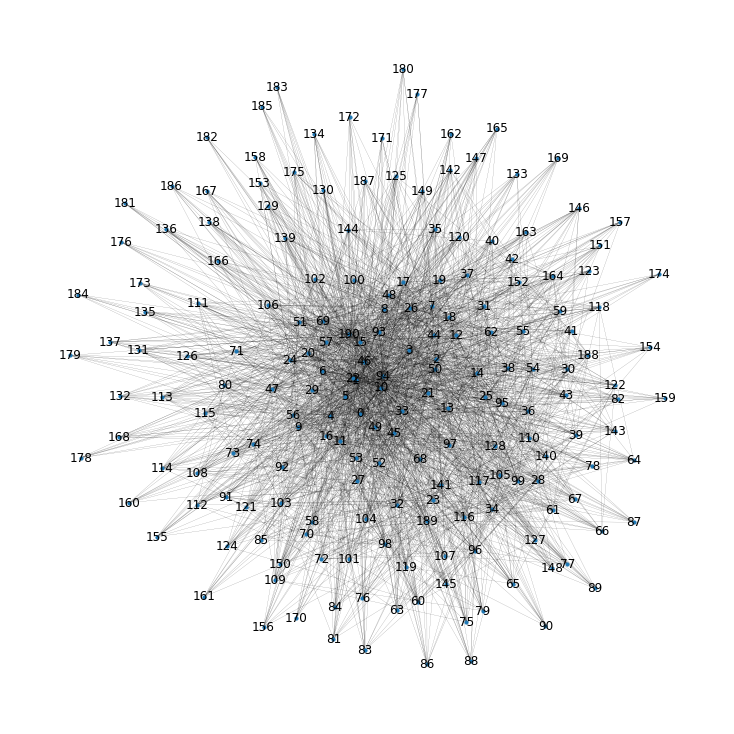

In [7]:
fig0 = plt.figure(figsize=(10,10))
nx.draw(G0, with_labels=True, node_size=10, width=0.1)

In [8]:
def SpectralRadius(A) -> float:
    W, V   = scipy.sparse.linalg.eigs(A) # largest eigenvalue of adj matrix
    eigens = sorted(W, reverse=True)
    lambd  = float(eigens[0])
    
    return lambd

In [9]:
def KatzGrid(spectral_rad: float, grid_points: int=9) -> np.ndarray:
    alphas = np.linspace(0, 1/spectral_rad, num=grid_points)
    alphas = alphas[1:len(alphas)-1]
    
    return alphas

In [10]:
def KatzCentralityNX(A, Graph: nx.classes.graph.Graph) -> tuple((np.ndarray, np.ndarray)):
    largest_eigen_value = SpectralRadius(A)
    
    alphas = KatzGrid(largest_eigen_value)
    
    katz_centralities = np.zeros((A.shape[0], len(alphas)))

    for i, alpha in enumerate(alphas):
        cent = nx.katz_centrality(Graph, alpha=alpha)
        katz_centralities[:, i] = np.array(list(cent.values())).astype(float)
        
    return (katz_centralities, alphas)

In [11]:
KatzNX, alpha_grid = KatzCentralityNX(CA.AdjacencyMatrix, CA.Graph)

/tmp/ipykernel_791/651843634.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  lambd  = float(eigens[0])


In [13]:
def VisualizeNodeCentrality(centrality_vector: np.ndarray, grid: np.ndarray) -> None:
    fig1 = plt.figure(figsize=(10, 10))
    for i in range(centrality_vector.shape[0]):
        plt.plot(grid, centrality_vector[i, :])
    plt.show()

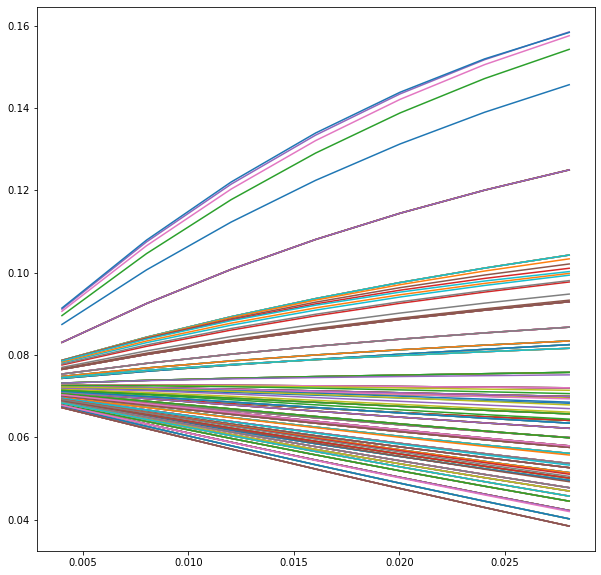

In [14]:
VisualizeNodeCentrality(KatzNX, alpha_grid)

In [15]:
def KatzCentralityV2(A, Graph: nx.classes.graph.Graph) -> tuple((np.ndarray, np.ndarray)):
    largest_eigen_value = SpectralRadius(A)
    
    alphas = KatzGrid(largest_eigen_value)
    
    katz_centralities_mine = np.zeros((A.shape[0], len(alphas)))

    for i, alpha in enumerate(alphas):
        centr = np.linalg.inv(np.eye(A.shape[0]) - alpha*A) * np.ones((A.shape[0], 1))
        katz_centralities_mine[:, i] = np.reshape(centr, centr.shape[0])
    
    return katz_centralities_mine, alphas

In [16]:
KatzV2, alpha_gridV2 = KatzCentralityV2(CA.AdjacencyMatrix, CA.Graph)

/tmp/ipykernel_791/651843634.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  lambd  = float(eigens[0])


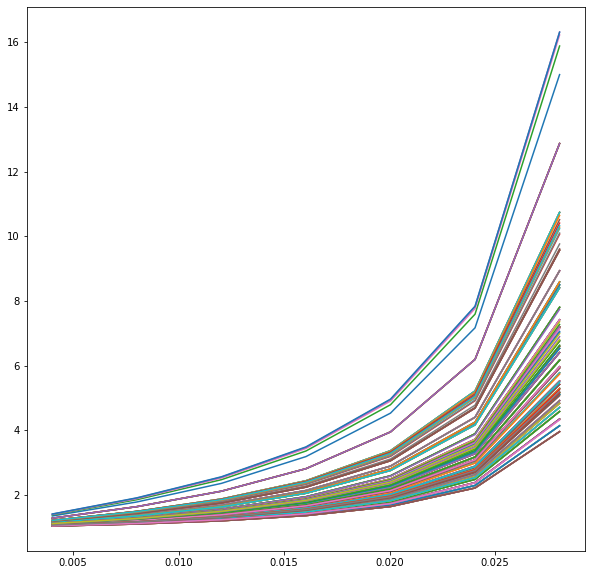

In [17]:
VisualizeNodeCentrality(KatzV2, alpha_gridV2)

In [18]:
def NBTCentrality(A) -> tuple((np.ndarray, np.ndarray)):
    ts = np.linspace(0, 1, num=9)
    ts = ts[1:len(ts)-1]
    
    nbtw_centralities = np.zeros((A.shape[0], len(ts)))

    for i, t in enumerate(ts):
        I = np.eye(A.shape[0], A.shape[0])
        e = np.ones((A.shape[0], 1))

        d = np.sum(A, axis=1)
        D = np.identity(A.shape[0])
        D[np.diag_indices_from(D)] = np.reshape(d, d.shape[0])

        Mt = I - t*A + (D - I) * t**2

        centr_nbt = np.linalg.inv(Mt) * e * (1 - t**2)
        nbtw_centralities[:, i] = np.reshape(centr_nbt, centr_nbt.shape[0])
        
    return (nbtw_centralities, ts)

In [19]:
NBTcent, grid_t = NBTCentrality(CA.AdjacencyMatrix)

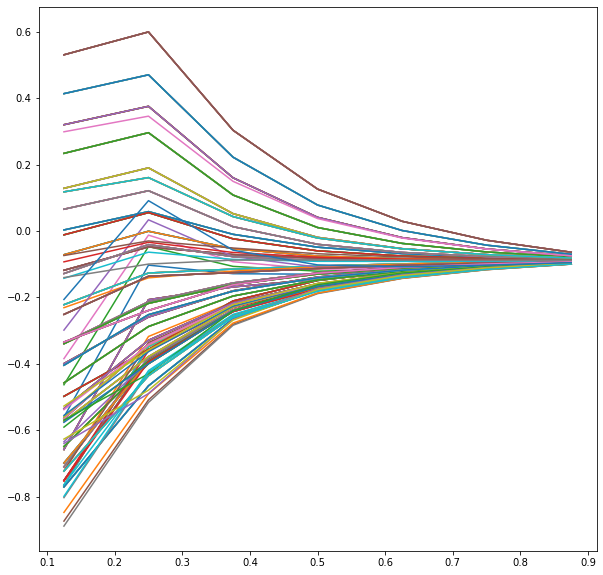

In [20]:
VisualizeNodeCentrality(NBTcent, grid_t)

In [21]:
def generate_groups(range_to_group):
    lb           = min(range_to_group)
    ub           = max(range_to_group)
    
    intervals    = np.linspace(lb, ub, 6)
    
    boolmap      = list(map(lambda x: x > intervals, range_to_group))
    group_labels = list(map(lambda x: np.where((x > intervals) == False)[0][0],  range_to_group))
    
    return (group_labels, intervals)

In [22]:
def generate_attributes(groups_lbl): 
    group_attr = {}
    for node in range(len(groups_lbl)):
        group_attr[node] = {"color_group": str(groups_lbl[node])}
    
    return group_attr

In [26]:
def CentralityColorMap(Graph: nx.classes.graph.Graph) -> None:
    # get unique groups
    groups = set(nx.get_node_attributes(Graph,'color_group').values())
    mapping = dict(zip(sorted(groups), count()))
    nodes = Graph.nodes()
    colors = [mapping[Graph.nodes[n]['color_group']] for n in nodes]

    # drawing nodes and edges separately so we can capture collection for colobar
    fig4 = plt.figure(figsize=(15,15))
    pos = nx.spring_layout(Graph)
    ec = nx.draw_networkx_edges(Graph, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(Graph, pos, nodelist=nodes, node_color=colors, 
                                node_size=15, cmap=plt.cm.jet)
    plt.colorbar(nc)
    plt.axis('off')
    plt.show()

[1.03814775 1.11286005 1.18757236 1.26228467 1.33699697 1.41170928]


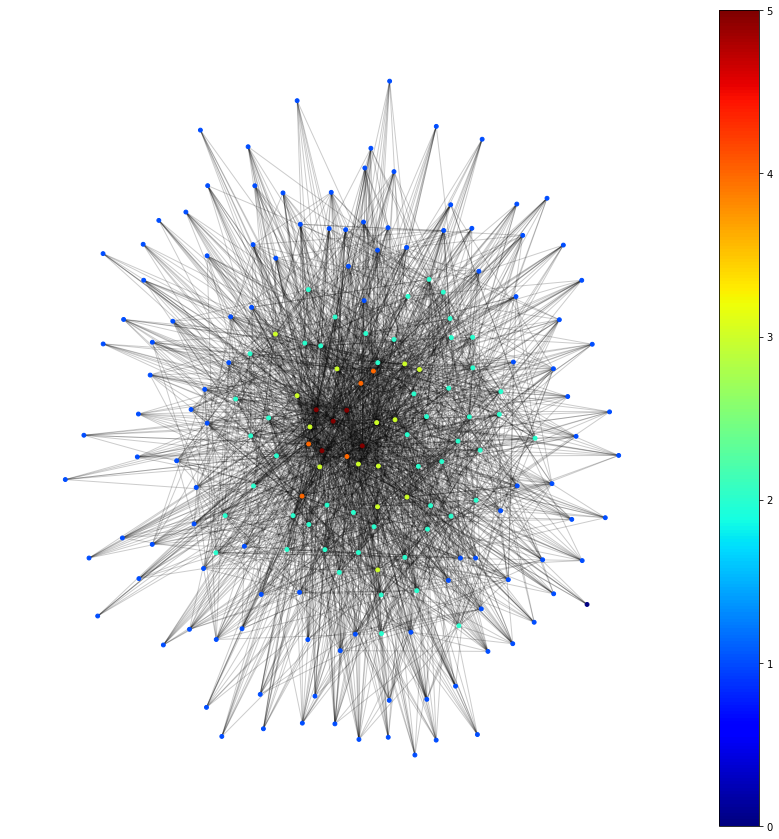

[1.10116283 1.26334609 1.42552935 1.58771261 1.74989587 1.91207914]


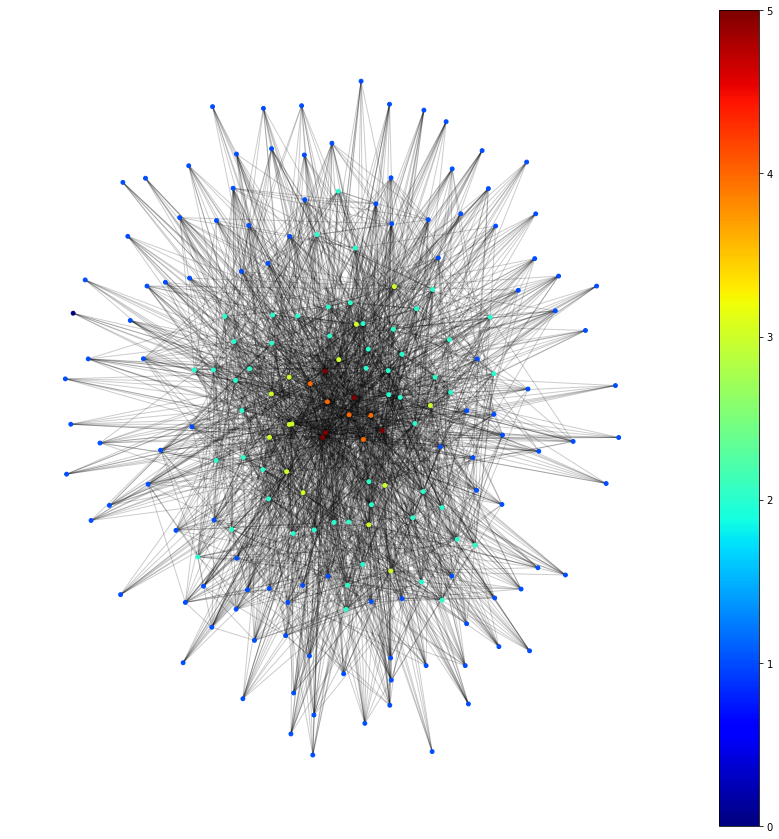

[1.20090877 1.473384   1.74585923 2.01833446 2.2908097  2.56328493]


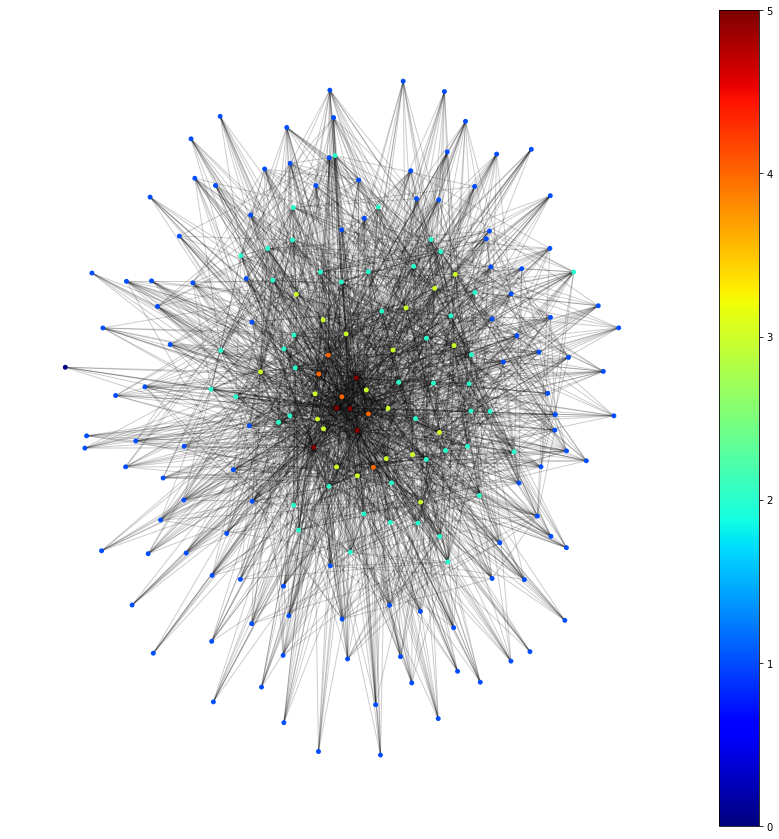

[1.36190705 1.78693767 2.21196829 2.63699891 3.06202953 3.48706015]


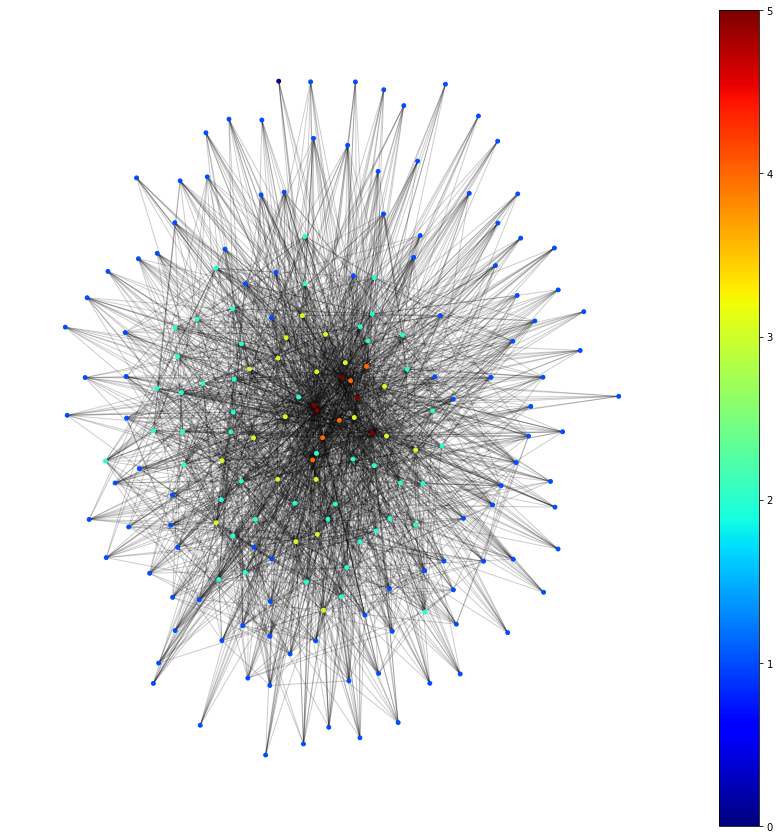

[1.64212706 2.30666648 2.9712059  3.63574532 4.30028474 4.96482416]


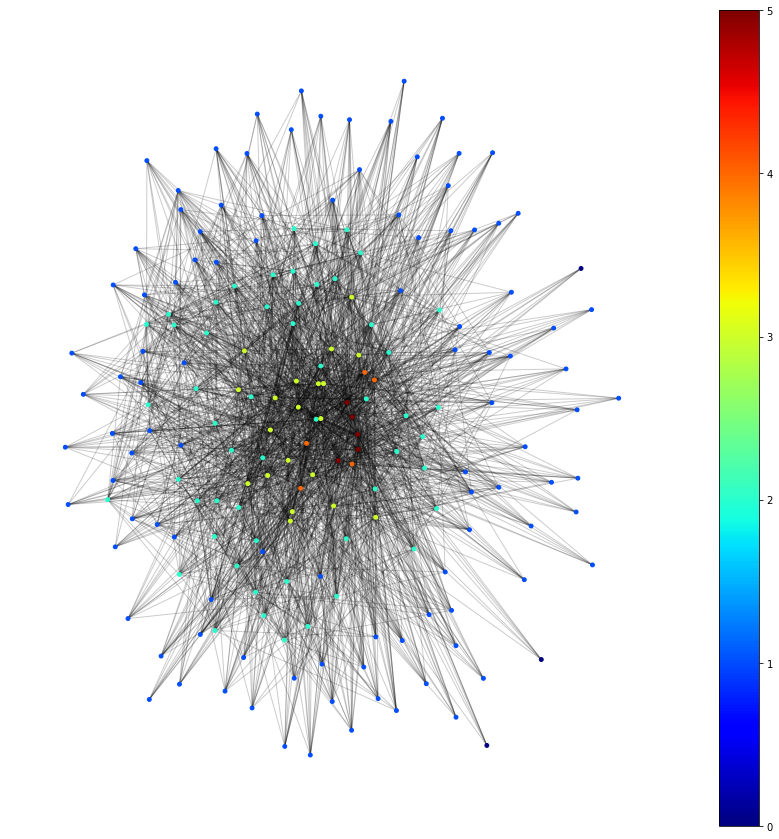

[2.21628114 3.34058346 4.46488577 5.58918808 6.7134904  7.83779271]


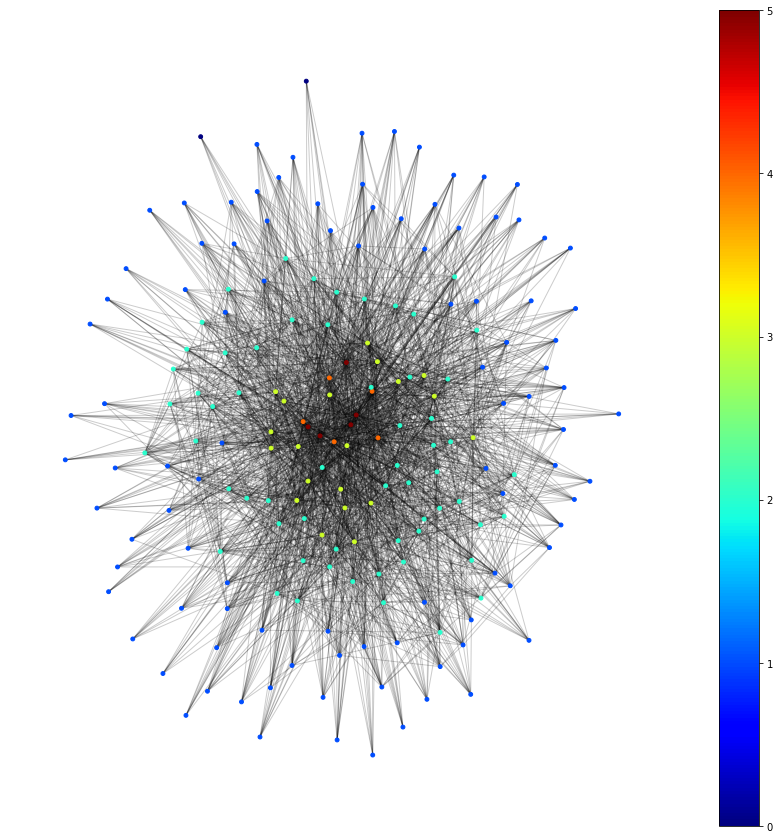

[ 3.95906344  6.43129311  8.90352279 11.37575246 13.84798213 16.32021181]


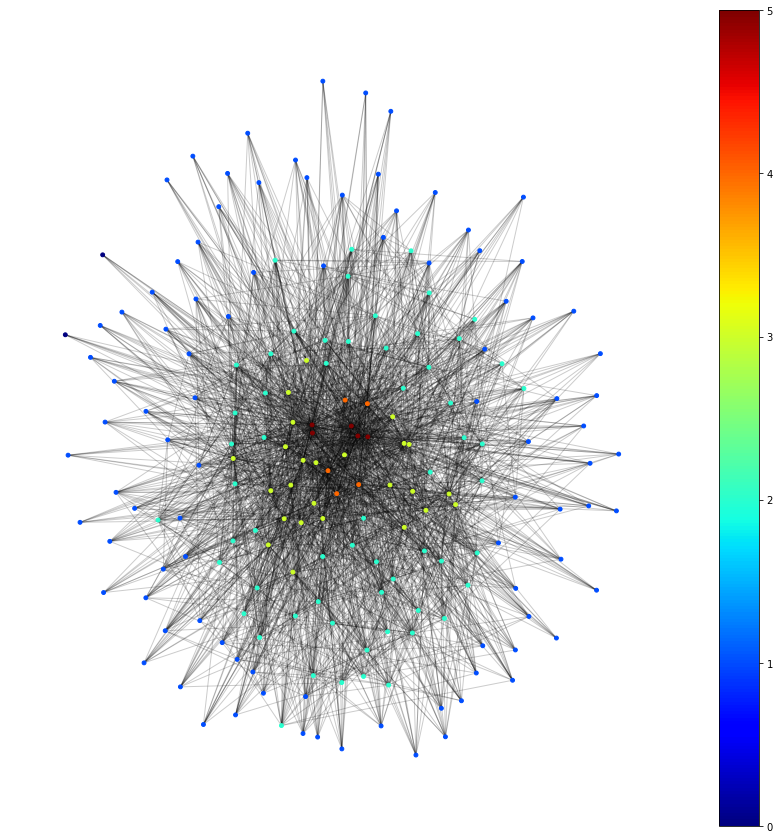

In [27]:
for i in range(KatzV2.shape[1]):
    centrality_vector = KatzV2[:, i]
    glbl, ints = generate_groups(centrality_vector)
    test_attribute = generate_attributes(glbl)
    nx.set_node_attributes(CA.Graph, test_attribute)
    print(ints)
    CentralityColorMap(CA.Graph) 

[-0.88903091 -0.60505257 -0.32107424 -0.0370959   0.24688244  0.53086078]


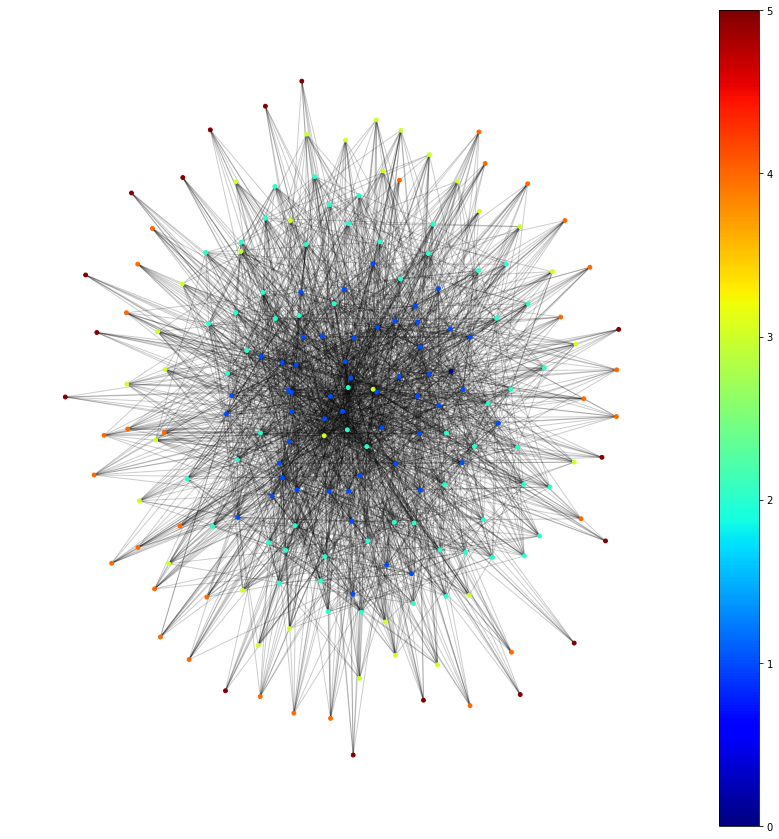

[-0.51646579 -0.2932107  -0.06995561  0.15329947  0.37655456  0.59980965]


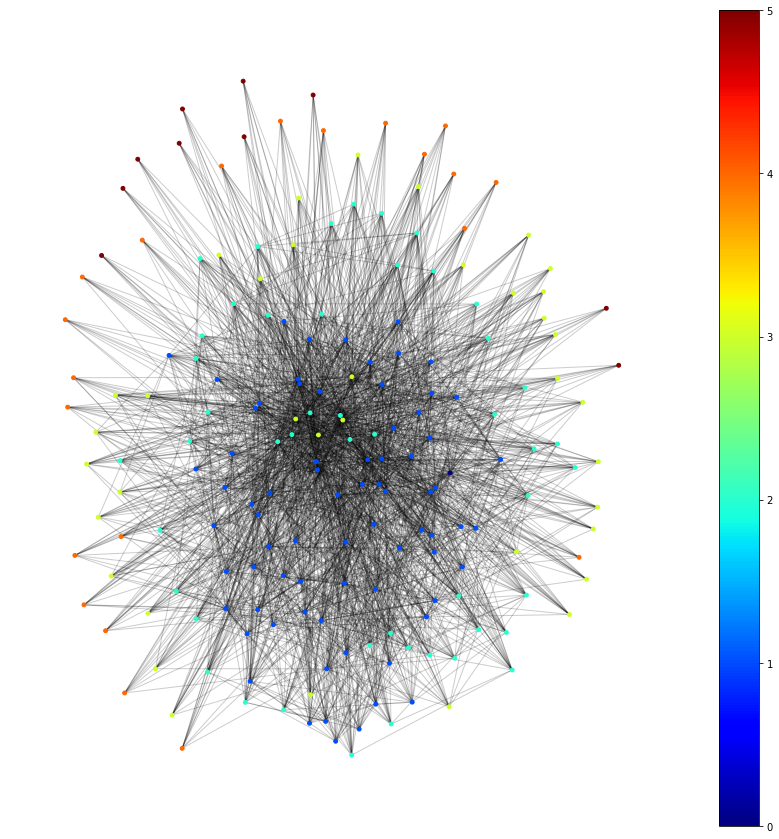

[-0.2839966  -0.16649267 -0.04898875  0.06851517  0.1860191   0.30352302]


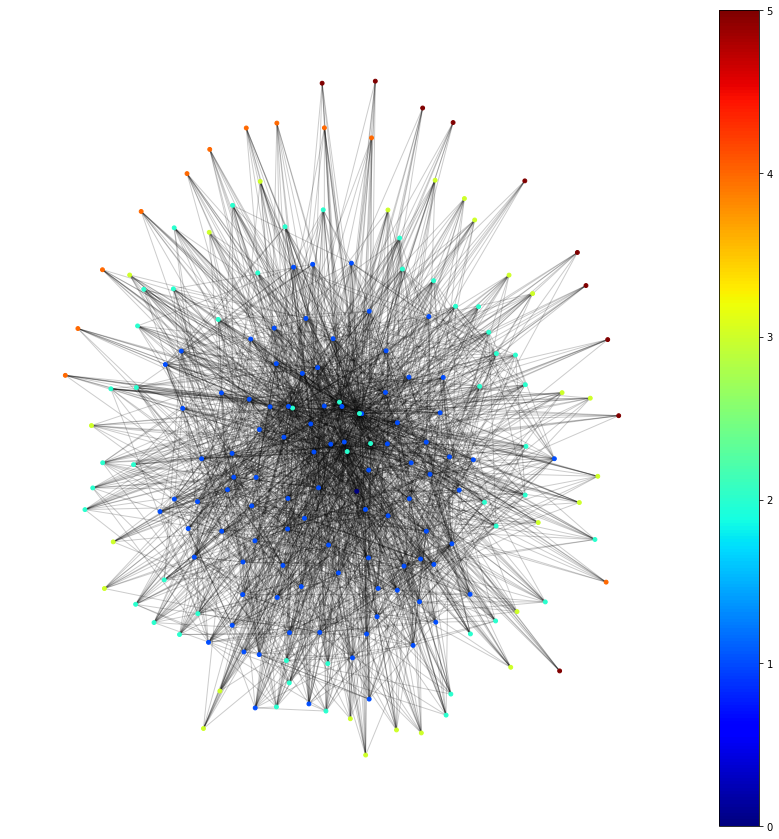

[-0.1886889  -0.12569283 -0.06269675  0.00029933  0.06329541  0.12629149]


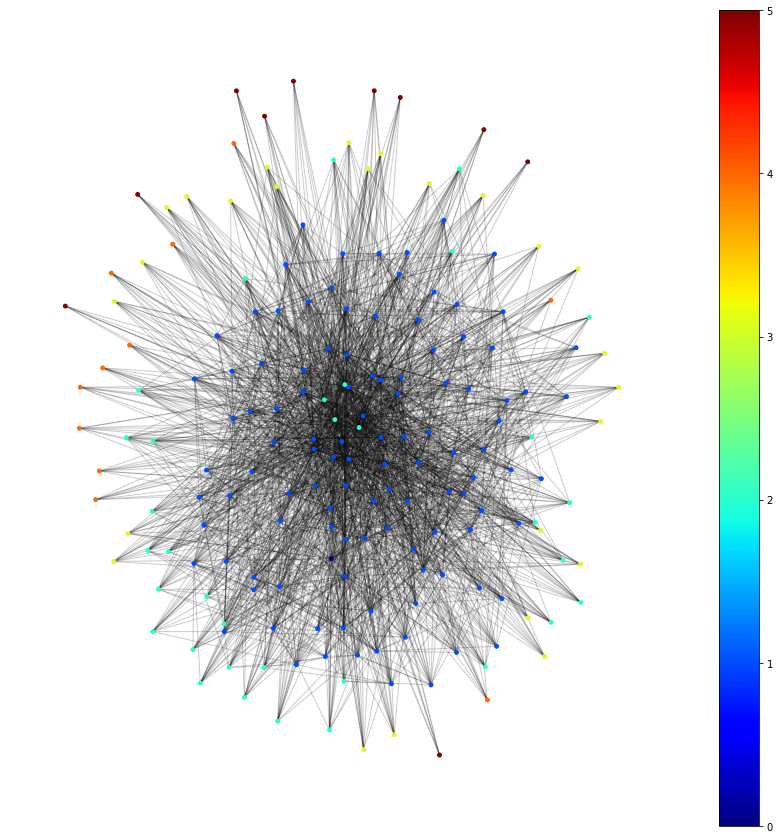

[-0.14287715 -0.10845452 -0.0740319  -0.03960927 -0.00518665  0.02923598]


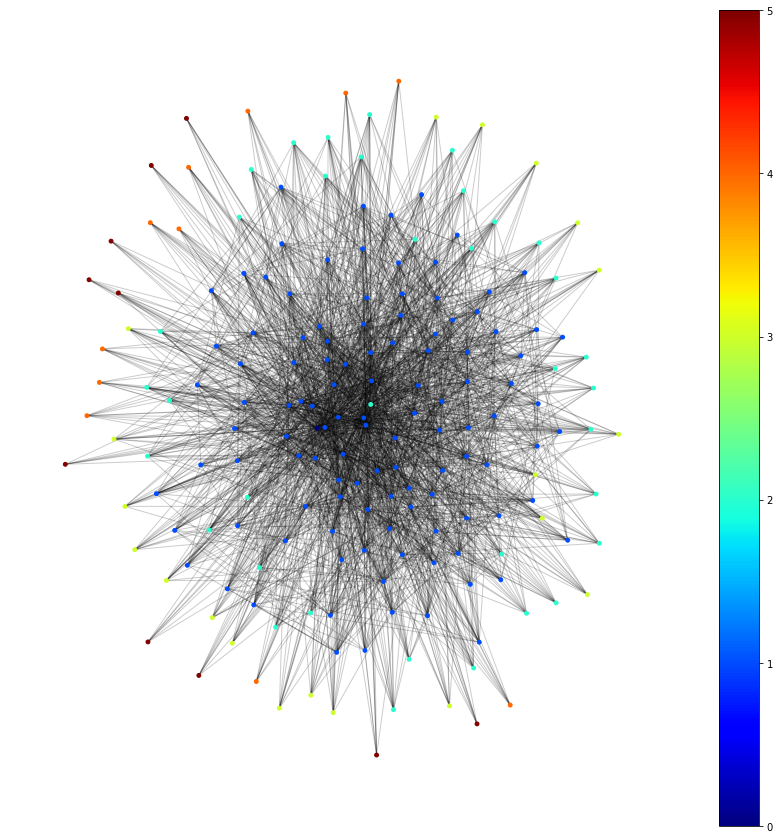

[-0.11666514 -0.09890994 -0.08115475 -0.06339955 -0.04564435 -0.02788915]


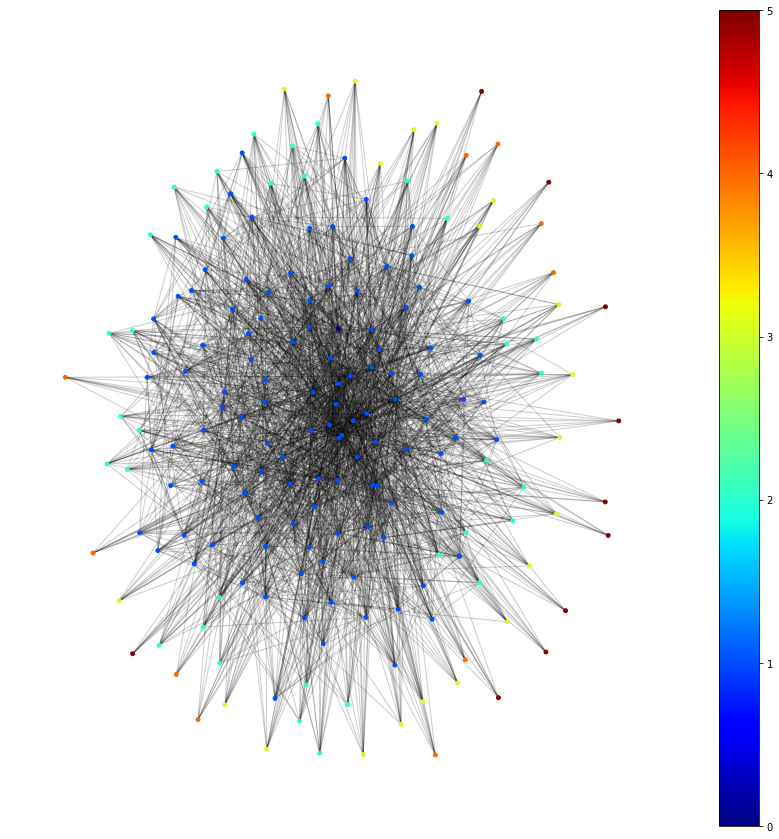

[-0.09980079 -0.09263297 -0.08546516 -0.07829735 -0.07112954 -0.06396173]


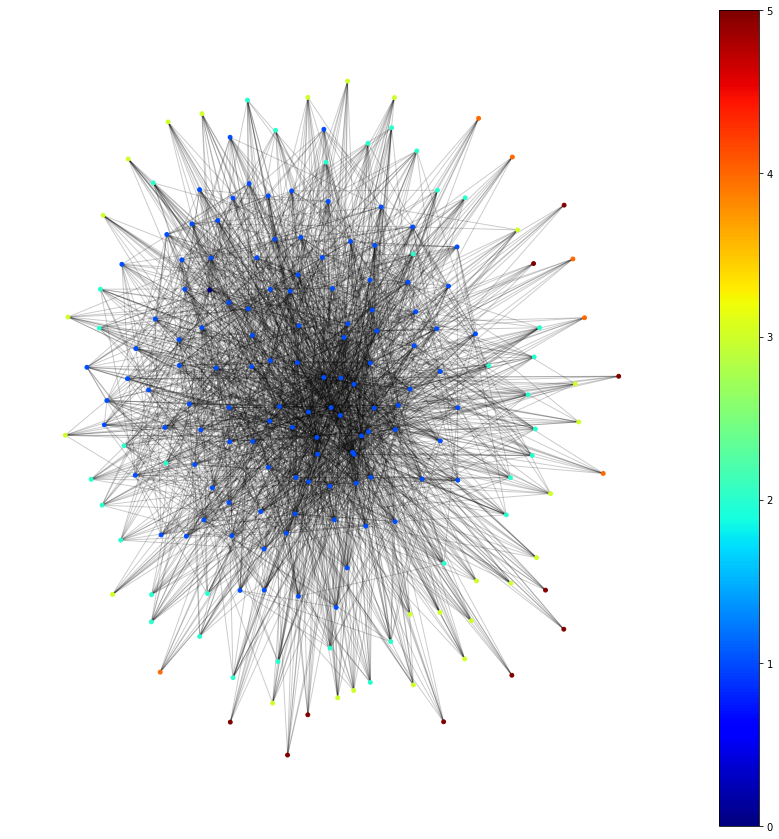

In [28]:
for i in range(NBTcent.shape[1]):
    centrality_vector = NBTcent[:, i]
    glbl, ints = generate_groups(centrality_vector)
    test_attribute = generate_attributes(glbl)
    nx.set_node_attributes(CA.Graph, test_attribute)
    print(ints)
    CentralityColorMap(CA.Graph) 